# Ticketdaten der Loy & Hutz Solutions GmbH erkunden und vorverarbeiten

### Benötigte Pakete importieren und Einstellungen setzen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
import spacy

from nltk.corpus import stopwords
from langdetect import detect
from wordcloud import WordCloud

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Ticketdaten einlesen

In [3]:
ticket_df = pd.read_excel('tickets.xlsx')
ticket_df

,Ticket-ID,Datum,Stichwort,Meldung,Ticketart
0,TN-2302-00004,2023-02-01 00:00:00,[Failed] Backup Copy Job Azure\HalfDailyBackup...,_x000D__x000D_\tBackup Copy job: Backup Copy J...,IT
1,TN-2302-00007,2023-02-01 00:00:00,[Warning] Backup Copy Job Azure\HalfDailyBacku...,_x000D__x000D_\tBackup Copy job: Backup Copy J...,IT
2,TN-2302-00008,2023-02-01 00:00:00,[Warning] Backup Copy Job Azure\HalfDailyBacku...,_x000D__x000D_\tBackup Copy job: Backup Copy J...,IT
3,TN-2302-00009,2023-02-01 00:00:00,Error message appears and saving is not possib...,Error message appears and saving is not possib...,Bug
4,TN-2302-00013,2023-02-01 00:00:00,[Ext.] #207695: Wave sehr langsam: Einzelfall?,"Hallo Herr Willi, _x000D__x000D_wir bekommen v...",Support
...,...,...,...,...,...
52045,TN-1801-00087,2018-01-02 00:00:00,Bemerkungs Spalte,"Guten Tag,_x000D_\n_x000D_\nunser Kunde schrei...",Wunsch
52046,TN-1801-00097,2018-01-02 00:00:00,Kalenderwochen fehlen,Kalenderwochen fehlen_x000D_\n_x000D_\n* neuen...,Bug
52047,TN-1801-00099,2018-01-02 00:00:00,#KD3019#,"Hallo Support, _x000D_\nAktuell taucht eine Fr...",Wunsch
52048,TN-1801-00101,2018-01-02 00:00:00,RE: Demoversion für den Kunden Universität Sie...,_x000D__x000D_Siehe Feedback TN-1801-00092....,Bug


### Allgemeine Informationen über das DataFrame ansehen

In [4]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52050 entries, 0 to 52049
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ticket-ID  52050 non-null  object
 1   Datum      52050 non-null  object
 2   Stichwort  51947 non-null  object
 3   Meldung    52019 non-null  object
 4   Ticketart  52050 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


### Alle leere Zeilen löschen

In [5]:
ticket_df.Stichwort.replace(r'', np.nan, regex=True, inplace=True)
ticket_df.Meldung.replace(r'', np.nan, regex=True, inplace=True)
ticket_df = ticket_df[ticket_df.Stichwort.notna()]
ticket_df = ticket_df[ticket_df.Meldung.notna()]

In [6]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51946 entries, 0 to 52049
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ticket-ID  51946 non-null  object
 1   Datum      51946 non-null  object
 2   Stichwort  51946 non-null  object
 3   Meldung    51946 non-null  object
 4   Ticketart  51946 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB


### Funktion zur Textbereinigung definieren

In [7]:
def clean_tickets(text):
    
    if text is None: # Text is None abfangen
        return ''
    
    text = str(text)
    
    text = re.sub('_x000D_', '', text) # _x000D_ entfernen --- entsteht in Excel durch den ASCII-Code für Line Feed
    
    text = re.sub('https?:\/\/\S*', '', text) # URLs entfernen
    
    text = re.sub('\d+', '', text) # Zahlen entfernen
    
    for c in string.punctuation:
        text = text.replace(c, ' ') # Die Zeichen ---> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~ <--- entfernen
    
    text = re.sub('Ä', 'Ae', text) # Umlaute umwandeln  
    text = re.sub('ä', 'ae', text)
    text = re.sub('Ö', 'Oe', text)
    text = re.sub('ö', 'oe', text)
    text = re.sub('Ü', 'Ue', text)
    text = re.sub('ü', 'ue', text)
    text = re.sub('ß', 'ss', text)
    
    text = re.sub(' \w ', ' ', text) # Alleinstehende Zeichen entfernen
        
    text = re.sub('\n', ' ', text) # Zeilenumbrüche entfernen --- \n, \t, \r sind Escape Character
    
    text = re.sub('\r', ' ', text) # Carriage Returns entfernen
    
    text = re.sub('\t', ' ', text) # Tabulatoren entfernen
    
    text = re.sub(' +', ' ', text).strip() # Whitespace entfernen
    
    text = text.encode('ascii', 'ignore').decode() # Text in ASCII umwandeln
    
    # text = text.lower()

    return text

### Funktionen zur Stopp-Wort-Entfernung definieren

In [8]:
german_stop_words = stopwords.words('german')
ticket_stop_words = ['EmmyNoetherStrasse', 'EmmyNoetherStr', 'EmmyNoetherStraß', 'Solutions', 'www', 'de', 'Loy', 'Hutz', 'Freiburg', 'Loyhutz', 'FolgenSieuns', 'AllegesetzlichenPflichtangabenfindenSiehier', 'willig', 'Grueß', 'GmbH', 'LoyHutzSolutionsGmbH', 'Firma', 'BachelorofScience', 'Ringstr', 'Loehne', 'Gruessen', 'freundlichen']

def remove_stop_words(text):
    tokens = text.split()
    return ' '.join([t for t in tokens if (not t in german_stop_words) and (not t in ticket_stop_words)])

### Funktion zur Lemmatisierung definieren

In [9]:
nlp = spacy.load('de_core_news_sm')
# !python -m spacy download de_core_news_sm

In [10]:
def lemmatize_text_spacy(text):
    spacy_doc = nlp(text)
    lemmatize_tokens = [token.lemma_ for token in spacy_doc] # token.text, token.pos_, token.dep_, token.lemma_
    lemmatize_text = ' '.join(lemmatize_tokens)
    return lemmatize_text

### Englische Tickets entfernen, neu indizieren und Zwischeninformationen ansehen

In [11]:
ticket_df['Sprache'] = ''

for index, row in ticket_df.iterrows():
    try:
        lang = detect(row['Meldung'])
    except:
        ticket_df.at[index, 'Sprache'] = 'en'
    else:
        if lang == 'de':
            ticket_df.at[index, 'Sprache'] = 'de'
        else:
            ticket_df.at[index, 'Sprache'] = 'en'

ticket_df.Sprache.replace(r'', np.nan, regex=True, inplace=True)
ticket_df.drop(ticket_df[ticket_df['Sprache'] != 'de'].index, inplace = True)
ticket_df.reset_index(drop=True, inplace=True)
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44984 entries, 0 to 44983
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ticket-ID  44984 non-null  object
 1   Datum      44984 non-null  object
 2   Stichwort  44984 non-null  object
 3   Meldung    44984 non-null  object
 4   Ticketart  44984 non-null  object
 5   Sprache    44984 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


### Stichwort_cleaned, Meldung_cleaned, Meldung_BERT setzen

In [12]:
ticket_df['Stichwort_cleaned'] = ''

for index, row in ticket_df.iterrows():
    try:
        stichwort = row['Stichwort']
        stichwort_cleaned = clean_tickets(stichwort)
    except:
        ticket_df.at[index, 'Stichwort_cleaned'] = ''
    else:
        ticket_df.at[index, 'Stichwort_cleaned'] = stichwort_cleaned

In [13]:
ticket_df['Meldung_cleaned'] = ''
ticket_df['Meldung_BERT'] = ''

for index, row in ticket_df.iterrows():
    try:
        meldung = row['Meldung']
        meldung_cleaned = clean_tickets(meldung)
    except:
        ticket_df.at[index, 'Meldung_cleaned'] = ''
        ticket_df.at[index, 'Meldung_BERT'] = ''
    else:
        ticket_df.at[index, 'Meldung_cleaned'] = meldung_cleaned
        ticket_df.at[index, 'Meldung_BERT'] = meldung_cleaned

### Ticketlängen setzen und Histogramm ausgeben

In [14]:
ticket_df['Länge'] = 0

for index, row in ticket_df.iterrows():
    try:
        length = len(row['Meldung_cleaned'].split())
    except:
        ticket_df.at[index, 'Länge'] = 0
    else:
        ticket_df.at[index, 'Länge'] = length
        
ticket_df = ticket_df[ticket_df.Länge > 0]

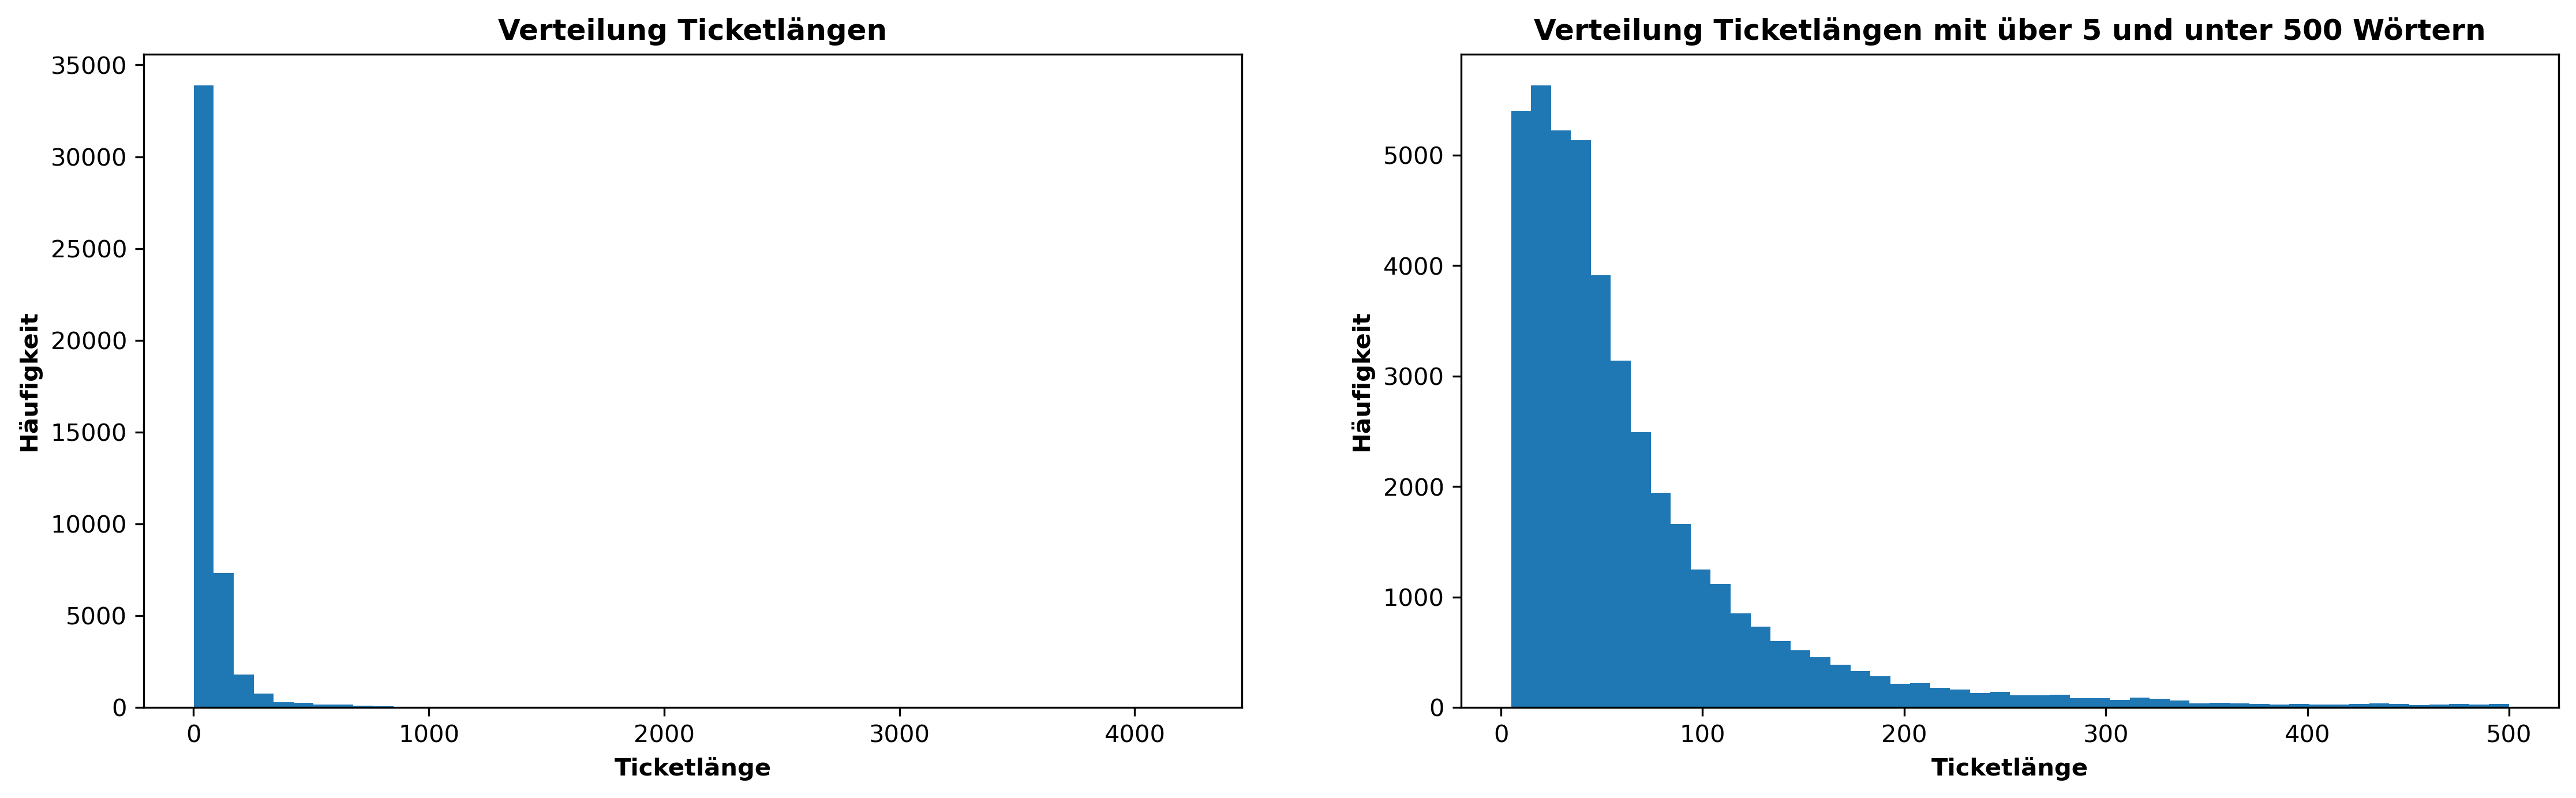

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 5))

ax1.hist(ticket_df.Länge, bins=50)
ax2.hist([l for l in ticket_df.Länge if (l >= 5) and (l <= 500)], bins=50)

ax1.set_title('Verteilung Ticketlängen', fontweight='bold')
ax1.set_xlabel('Ticketlänge', fontweight='bold')
ax1.set_ylabel('Häufigkeit', fontweight='bold')

ax2.set_title('Verteilung Ticketlängen mit über 5 und unter 500 Wörtern', fontweight='bold')
ax2.set_xlabel('Ticketlänge', fontweight='bold')
ax2.set_ylabel('Häufigkeit', fontweight='bold')

fig.savefig('pictures/ticketlength_histo.png', dpi=600)
plt.show()

### Statistische Werte ausgeben

In [16]:
describe_df = ticket_df['Länge'].describe()
print(f"Die minimale Anzahl an Wörtern beträgt: {describe_df.loc['min']}")
print(f"Die durchschnittliche Anzahl an Wörtnern beträgt: {describe_df.loc['mean']}")
print(f"Die mediane Anzahl an Wörtern beträgt: {describe_df.loc['50%']}")
print(f"Die maximale Anzahl an Wörtern beträgt: {describe_df.loc['max']}")

Die minimale Anzahl an Wörtern beträgt: 1.0
Die durchschnittliche Anzahl an Wörtnern beträgt: 76.97172327938823
Die mediane Anzahl an Wörtern beträgt: 45.0
Die maximale Anzahl an Wörtern beträgt: 4242.0


In [17]:
ticket_df = ticket_df[(ticket_df.Länge >= 5) & (ticket_df.Länge <= 500)]
ticket_df

,Ticket-ID,Datum,Stichwort,Meldung,Ticketart,Sprache,Stichwort_cleaned,Meldung_cleaned,Meldung_BERT,Länge
0,TN-2302-00013,2023-02-01 00:00:00,[Ext.] #207695: Wave sehr langsam: Einzelfall?,"Hallo Herr Willi, _x000D__x000D_wir bekommen v...",Support,de,Ext Wave sehr langsam Einzelfall,Hallo Herr Willi wir bekommen von einem Kolleg...,Hallo Herr Willi wir bekommen von einem Kolleg...,136
1,TN-2302-00016,2023-02-01 00:00:00,Per E-Mail senden: license.lhlic,könnt Ihr bitte meine deltaCAD-Demodatenbank-...,Lizenz,de,Per Mail senden license lhlic,koennt Ihr bitte meine deltaCAD Demodatenbank ...,koennt Ihr bitte meine deltaCAD Demodatenbank ...,10
2,TN-2302-00017,2023-02-01 00:00:00,Bestellung eines Headsets,"Hallo Zusammen,_x000D_\n_x000D_\nich habe aktu...",IT,de,Bestellung eines Headsets,Hallo Zusammen ich habe aktuell probleme mit m...,Hallo Zusammen ich habe aktuell probleme mit m...,44
3,TN-2302-00018,2023-02-01 00:00:00,Online Package Repo - Changelog und Release Datum,Im Package Repo fehlt leider die Möglichkeit d...,Wunsch,de,Online Package Repo Changelog und Release Datum,Im Package Repo fehlt leider die Moeglichkeit ...,Im Package Repo fehlt leider die Moeglichkeit ...,78
4,TN-2302-00021,2023-02-01 00:00:00,Waveabsturz: Message => Object reference not s...,Wenn man auf einer Tätigkeit steht und auf die...,Bug,de,Waveabsturz Message Object reference not set t...,Wenn man auf einer Taetigkeit steht und auf di...,Wenn man auf einer Taetigkeit steht und auf di...,31
...,...,...,...,...,...,...,...,...,...,...
44979,TN-1801-00087,2018-01-02 00:00:00,Bemerkungs Spalte,"Guten Tag,_x000D_\n_x000D_\nunser Kunde schrei...",Wunsch,de,Bemerkungs Spalte,Guten Tag unser Kunde schreibt sich zu jedem D...,Guten Tag unser Kunde schreibt sich zu jedem D...,50
44980,TN-1801-00097,2018-01-02 00:00:00,Kalenderwochen fehlen,Kalenderwochen fehlen_x000D_\n_x000D_\n* neuen...,Bug,de,Kalenderwochen fehlen,Kalenderwochen fehlen neuen Auftrag zu Leistun...,Kalenderwochen fehlen neuen Auftrag zu Leistun...,19
44981,TN-1801-00099,2018-01-02 00:00:00,#KD3019#,"Hallo Support, _x000D_\nAktuell taucht eine Fr...",Wunsch,de,KD,Hallo Support Aktuell taucht eine Frage zu vfm...,Hallo Support Aktuell taucht eine Frage zu vfm...,161
44982,TN-1801-00101,2018-01-02 00:00:00,RE: Demoversion für den Kunden Universität Sie...,_x000D__x000D_Siehe Feedback TN-1801-00092....,Bug,de,RE Demoversion fuer den Kunden Universitaet Si...,Siehe Feedback TN DietmarBuerk SystemDevelopme...,Siehe Feedback TN DietmarBuerk SystemDevelopme...,205


### Vokabular vor Lemmatisierung zählen

In [18]:
voc_list = []

for index, row in ticket_df.iterrows():
    meldung_tokens = row['Meldung_cleaned'].split()
    voc_list.extend(meldung_tokens)

unique_tokens = set(voc_list)
count_voc = len(unique_tokens)


print(f"In den Ticketmeldungen sind {count_voc} verschiedene Wörter enthalten")

In den Ticketmeldungen sind 94563 verschiedene Wörter enthalten


### Stopp-Wörter aus Stichwort_cleaned und Meldung_cleaned entfernen

In [19]:
ticket_df['Stichwort_cleaned'] = ticket_df['Stichwort_cleaned'].apply(remove_stop_words)
ticket_df['Meldung_cleaned'] = ticket_df['Meldung_cleaned'].apply(remove_stop_words)

### Stichwort_lemmatized und Meldung_lemmatized setzen

In [20]:
ticket_df['Stichwort_lemmatized'] = ''

for index, row in ticket_df.iterrows():
    try:
        stichwort = row['Stichwort_cleaned']
        stichwort_lemmatized = lemmatize_text_spacy(stichwort)
    except:
        ticket_df.at[index, 'Stichwort_lemmatized'] = ''
    else:
        ticket_df.at[index, 'Stichwort_lemmatized'] = stichwort_lemmatized

In [21]:
ticket_df['Meldung_lemmatized'] = ''

for index, row in ticket_df.iterrows():
    try:
        meldung = row['Meldung_cleaned']
        meldung_lemmatized = lemmatize_text_spacy(meldung)
    except:
        ticket_df.at[index, 'Meldung_lemmatized'] = ''
    else:
        ticket_df.at[index, 'Meldung_lemmatized'] = meldung_lemmatized

### Vokabular nach Lemmatisierung zählen

In [22]:
voc_list_lemma = []

for index, row in ticket_df.iterrows():
    meldung_tokens_lemma = row['Meldung_lemmatized'].split()
    voc_list_lemma.extend(meldung_tokens_lemma)

unique_tokens_lemma = set(voc_list_lemma)
count_voc_lemma = len(unique_tokens_lemma)


print(f"In den Ticketmeldungen sind {count_voc_lemma} verschiedene Wörter enthalten")

In den Ticketmeldungen sind 88886 verschiedene Wörter enthalten


### WordCloud ausgeben

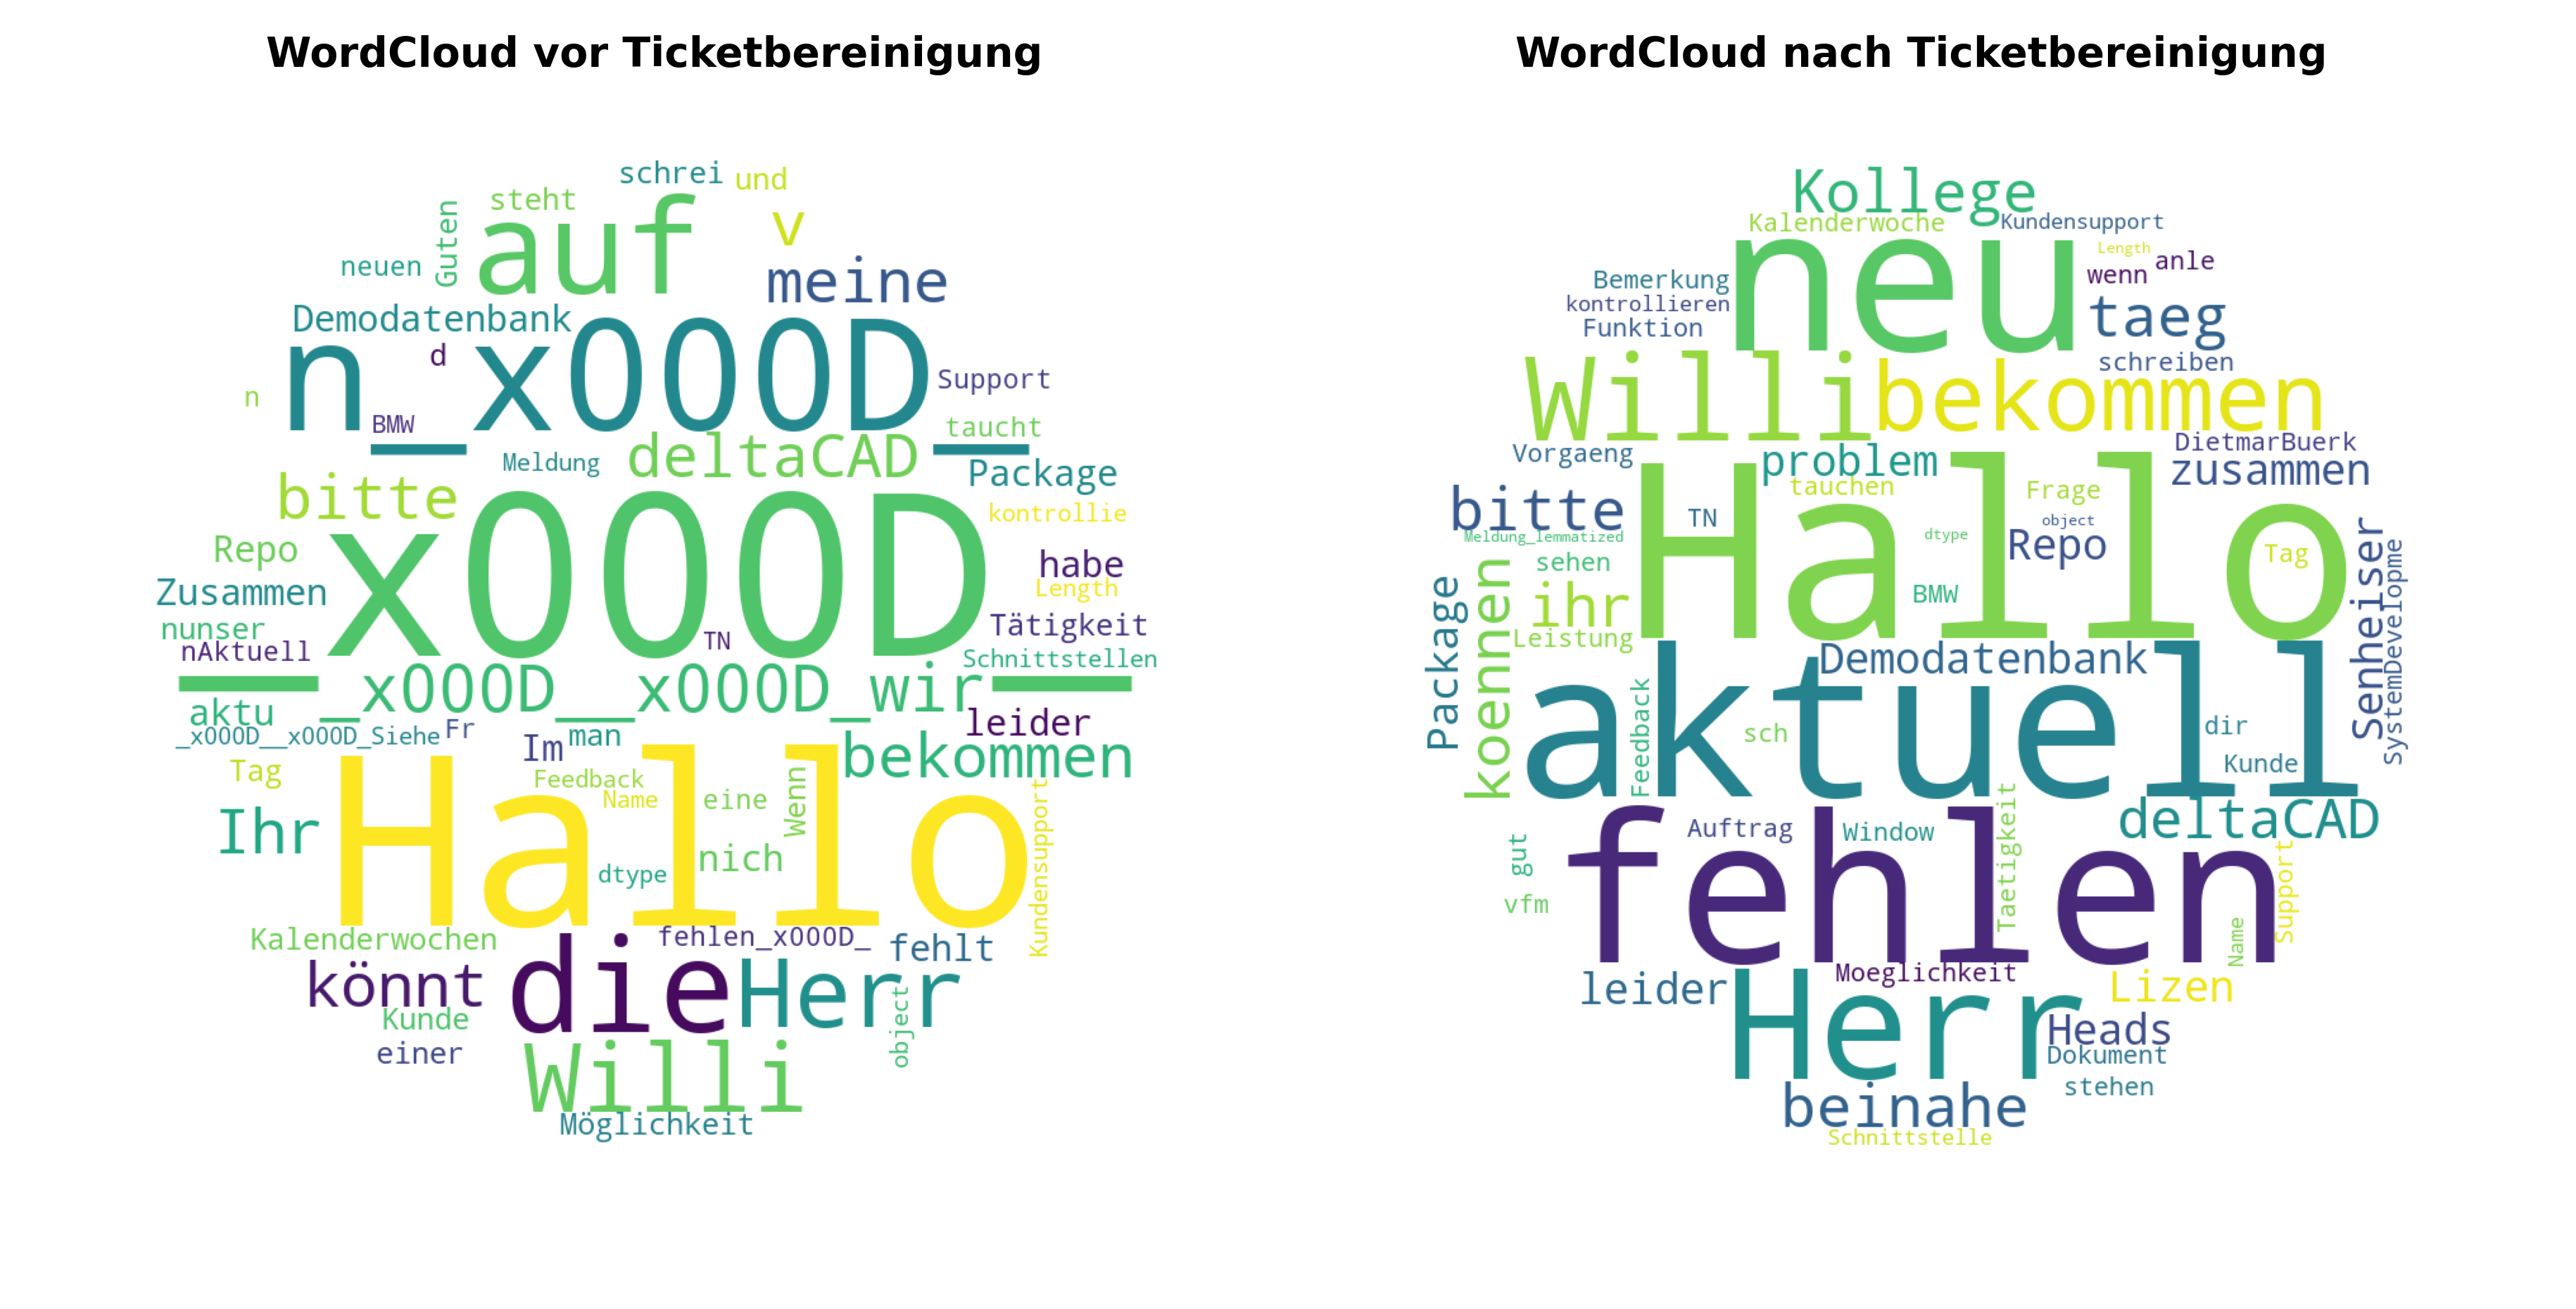

In [23]:
x, y = np.ogrid[:1000, :1000]
mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

wordcloud1 = WordCloud(background_color='white', width=1920, height=1080, mask=mask, random_state=24).generate(str(ticket_df['Meldung']))
wordcloud2 = WordCloud(background_color='white', width=1920, height=1080, mask=mask, random_state=24).generate(str(ticket_df['Meldung_lemmatized']))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))
axes[0].imshow(wordcloud1)
axes[0].set_title('WordCloud vor Ticketbereinigung', fontweight='bold', fontsize=14, y=0.95)
axes[1].imshow(wordcloud2)
axes[1].set_title('WordCloud nach Ticketbereinigung', fontweight='bold', fontsize=14, y=0.95)
axes[0].axis('off')
axes[1].axis('off')
plt.tight_layout(pad=0)
fig.savefig('pictures/wordcloud.png', dpi=600)
plt.show()

### Verteilung Ticketarten betrachten

In [24]:
ticket_df['Ticketart'].value_counts()

Bug                       16355
Wunsch                    10885
Support                    6748
IT                         4512
Vertrieb                   2226
Lizenz                     1923
Schulung                    426
Auftrag                     190
Sonstiges                   120
Dokumentation                39
Marketing                    14
Personal / Bewerbungen        4
bug                           3
it                            1
Infomaterial                  1
Name: Ticketart, dtype: int64

In [25]:
mapping_classes = {'Bug':0, 'Wunsch':1, 'Support':2, 'IT':3, 'Lizenz':4, 'Vertrieb':5, 'Auftrag':5, 'Sonstiges':5, 'Dokumentation':5, 'Schulung':5, 'Marketing':5, 'bug':0, 'Personal / Bewerbungen':5, 'it':3, 'Buchhaltung':5, 'Infomaterial':5}
ticket_df['Klasse'] = ticket_df['Ticketart'].map(mapping_classes)
tickettypes_value_count = ticket_df['Klasse'].value_counts()
tickettypes_value_count

0    16358
1    10885
2     6748
3     4513
5     3020
4     1923
Name: Klasse, dtype: int64

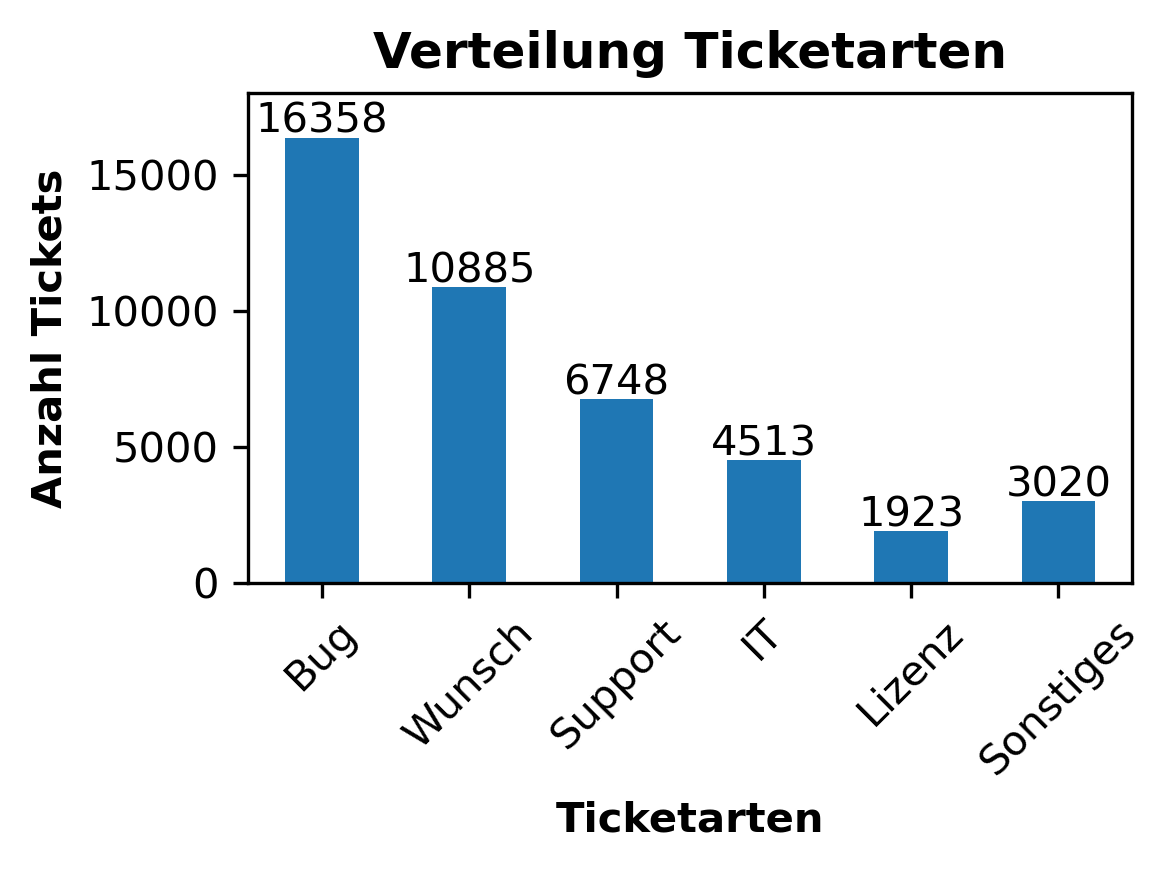

In [26]:
fig, ax = plt.subplots(figsize=(4, 3))
ticket_df.groupby('Klasse').Meldung.count().plot.bar(ylim=(0, 18000))

for i in range(len(tickettypes_value_count)):
    plt.text(i, tickettypes_value_count[i] + 175, tickettypes_value_count[i], ha='center')

plt.title('Verteilung Ticketarten', fontweight='bold')
plt.ylabel('Anzahl Tickets', fontweight='bold')
plt.xlabel('Ticketarten', fontweight='bold')
ax.set_xticklabels(['Bug', 'Wunsch', 'Support', 'IT', 'Lizenz', 'Sonstiges'], rotation=45)

plt.tight_layout()
fig.savefig('pictures/tickettype_contribution.png', dpi=600)
plt.show()

### Alle leeren Zeilen löschen

In [27]:
ticket_df.Stichwort.replace(r'', np.nan, regex=True, inplace=True)
ticket_df.Meldung.replace(r'', np.nan, regex=True, inplace=True)
ticket_df = ticket_df[ticket_df.Stichwort.notna()]
ticket_df = ticket_df[ticket_df.Meldung.notna()]

In [28]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43447 entries, 0 to 44983
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Ticket-ID             43447 non-null  object
 1   Datum                 43447 non-null  object
 2   Stichwort             43447 non-null  object
 3   Meldung               43447 non-null  object
 4   Ticketart             43447 non-null  object
 5   Sprache               43447 non-null  object
 6   Stichwort_cleaned     43447 non-null  object
 7   Meldung_cleaned       43447 non-null  object
 8   Meldung_BERT          43447 non-null  object
 9   Länge                 43447 non-null  int64 
 10  Stichwort_lemmatized  43447 non-null  object
 11  Meldung_lemmatized    43447 non-null  object
 12  Klasse                43447 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 4.6+ MB


### Bereinigte Ticketdaten als Excel exportieren

In [29]:
ticket_df.to_excel("tickets_cleaned.xlsx")